In [14]:
import requests
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt
from collections import Counter
from goatools.obo_parser import GODag
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
#Libraries____________________-

In [2]:
#fetch sequences
def uniprotSQ(query,file):
        res=requests.get("https://rest.uniprot.org/uniprotkb/stream?query="+query)
        with open(file,"w")as store_file:
                store_file.write(res.text)
        return "Results stored"
uniprotSQ("reviewed:true+go:*+length:[121+TO+121]&format=tsv&fields=accession,sequence,go_id","protSQLeq121.tsv")

'Results stored'

In [3]:
#read and pre-process
df = pd.read_csv("protSQLeq121.tsv", sep="\t")
print(df.head(3))
print("nrows: ",df.shape[0])
print("ncol: ",df.shape[1])
#____________________

    Entry                                           Sequence  \
0  C0HLF0  NLFQFRKMIKKMTKKEPVVYYAFYGCYCGKGGRGKPKDATDRCCFV...   
1  I6L8L6  SLFQLGKMILQETGKNPAASYGAYGCNCGVLGRGKPKDATDRCCYV...   
2  O14352  MLPLTLLNATQGRPILVELKNGETFNGHLENCDNYMNLTLREVIRT...   

                                   Gene Ontology IDs  
0  GO:0005509; GO:0005543; GO:0005576; GO:0006644...  
1  GO:0005509; GO:0005543; GO:0005576; GO:0006644...  
2  GO:0000387; GO:0000932; GO:0000956; GO:0005634...  
nrows:  1321
ncol:  3


go.obo: fmt(1.2) rel(2025-06-01) 43,448 Terms


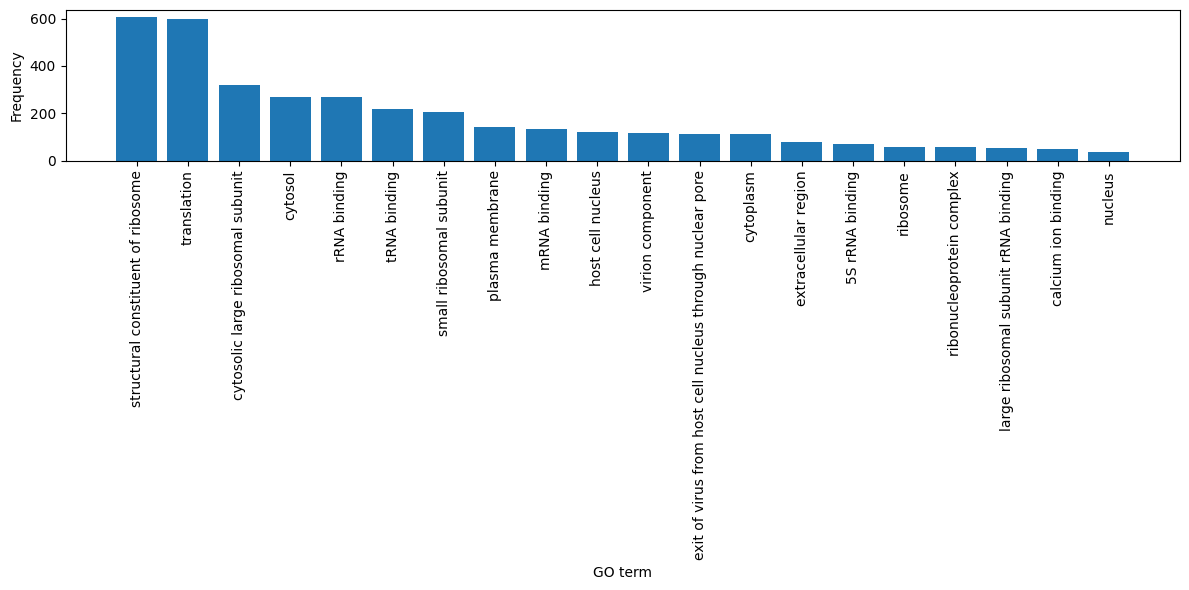

'Histogram created!'

In [13]:
#GO term histogram
go_dag = GODag("go.obo")
def go_hist(data_frame):
        go_terms=data_frame.iloc[:,-1] #last column is GO term
        go_terms=go_terms.str.split("; ")
        go_terms=list(chain.from_iterable(go_terms))
        go_terms=[go_dag[term].name for term in go_terms if term in go_dag]
        counts=Counter(go_terms)
        data=pd.DataFrame(counts.items(),columns=["GO","count"])
        data=data.sort_values(by="count",ascending=False)
        plt_data=data.head(20)
        plt.figure(figsize=(12,6))
        plt.bar(plt_data["GO"],plt_data["count"])
        plt.xticks(rotation=90)
        plt.xlabel("GO term")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
        return "Histogram created!"
go_hist(df)

In [15]:
#Encode protein sequences and GO terms_______________
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["Gene Ontology IDs"])
df["multi-hit GO"]=[list(row) for row in Y]

#__________________________________________________
def one_hit(sequence):
        clmns=["A","L","K","W","F","Y","G","D","N","C","T","V","M","R","I","S","P","H","E","Q"]
        rows=[i for i in sequence]
        df = pd.DataFrame(index=rows, columns=clmns)
        for row in df.index:
                for clmn in df.columns:
                        if row==clmn:
                                df.loc[row,clmn]=1
                        else:
                                df.loc[row,clmn]=0
        return df
#________________________________________________
matrices=[]
step=0
while step<df.shape[0]:
        matrices.append(one_hit(df.iloc[step,1]))
        print("sequence ", step, " added!")
        step+=1
df["one_hit matrix"]=matrices
df.to_csv('mouse_prot_MLin.csv', sep='\t', index=False)

sequence  0  added!
sequence  1  added!
sequence  2  added!
sequence  3  added!
sequence  4  added!
sequence  5  added!
sequence  6  added!
sequence  7  added!
sequence  8  added!
sequence  9  added!
sequence  10  added!
sequence  11  added!
sequence  12  added!
sequence  13  added!
sequence  14  added!
sequence  15  added!
sequence  16  added!
sequence  17  added!
sequence  18  added!
sequence  19  added!
sequence  20  added!
sequence  21  added!
sequence  22  added!
sequence  23  added!
sequence  24  added!
sequence  25  added!
sequence  26  added!
sequence  27  added!
sequence  28  added!
sequence  29  added!
sequence  30  added!
sequence  31  added!
sequence  32  added!
sequence  33  added!
sequence  34  added!
sequence  35  added!
sequence  36  added!
sequence  37  added!
sequence  38  added!
sequence  39  added!
sequence  40  added!
sequence  41  added!
sequence  42  added!
sequence  43  added!
sequence  44  added!
sequence  45  added!
sequence  46  added!
sequence  47  added!
se

In [17]:
mL_input=pd.read_csv('mouse_prot_MLin.csv', sep='\t')
mL_input.columns

Index(['Entry', 'Sequence', 'Gene Ontology IDs', 'multi-hit GO',
       'one_hit matrix'],
      dtype='object')

In [19]:
X_train,Y_train=mL_input['one_hit matrix'],mL_input['multi-hit GO']
print(X_train[0])

    A  L  K  W  F  Y  G  D  N  C  T  V  M  R  I  S  P  H  E  Q
N   0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
L   0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
F   0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
Q   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
F   0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
.. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. .. ..
P   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
S   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
E   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
K   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
C   0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0

[121 rows x 20 columns]


In [21]:
Y_train[0]

'[np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(1)]'

In [24]:
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout